# Gap filling in Mooring observations

Author: Steefan Contractor

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import xarray as xr

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
# Load PH100 Mooring data
wqm_ds = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_OZ_20100504_PH100_FV01_DOX2-aggregated-timeseries_END-20170828_C-20190819.nc') 

In [6]:
wqm_ds

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 33, OBSERVATION: 12073463)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    DOX2                      (OBSERVATION) float32 ...
    DOX2_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256

In [7]:
# Nominal depth location of WQM sensors
np.unique(wqm_ds.NOMINAL_DEPTH.values)

array([15. , 15.5, 24. ], dtype=float32)

In [8]:
# Drop unecessary variables and export to dataframe
wqm_ds = wqm_ds.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [9]:
# filter out bad quality data 
wqm_ds = wqm_ds.where(np.logical_and(wqm_ds.DOX2_quality_control > 0, wqm_ds.DOX2_quality_control < 3), drop = True)

In [10]:
wqm_ds = wqm_ds.where(np.logical_and(wqm_ds.PRES_REL_quality_control > 0, wqm_ds.PRES_REL_quality_control < 3), drop = True)

In [11]:
# create pd dataframe from scratch
data  = {'TIME': wqm_ds.TIME.values,
         'DOX2': wqm_ds.DOX2.values,
         'PRES': wqm_ds.PRES_REL.values}

wqm_df = pd.DataFrame(data, columns = ['TIME','DOX2','PRES'])
# set TIME as the indexing variable
wqm_df = wqm_df.set_index('TIME')

In [12]:
wqm_df

,DOX2,PRES
TIME,,
2010-05-04 02:00:00.000003328,191.253952,28.760000
2010-05-04 02:00:01.000007936,191.167465,28.799999
2010-05-04 02:00:02.000002560,191.140900,28.840000
2010-05-04 02:00:03.000007168,191.029449,28.870001
2010-05-04 02:00:04.000001792,191.110626,28.870001
...,...,...
2017-08-27 18:30:19.000000768,212.614594,17.709999
2017-08-27 18:30:20.000005632,212.614273,17.830000
2017-08-27 18:30:21.000000000,212.701523,17.910000


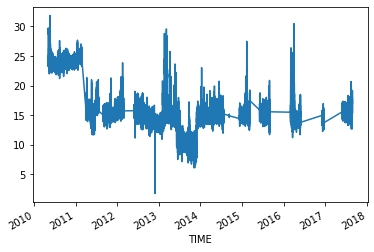

In [13]:
# Plot PRES over TIME
wqm_df.PRES.plot()

In [14]:
# save maximum pressure value for subsetting temperature later
max_pres = wqm_df.PRES.max()

In [15]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [16]:
# create a column with pressure bin labels
wqm_df['PRES_BIN'] = pd.cut(wqm_df.PRES, bins = bins, labels = labs)

In [17]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
wqm_df = wqm_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [18]:
wqm_df

DOX2
PRES_BIN TIME                           
1.0      2012-11-28 22:00:00  219.715591
3.0      2012-11-28 22:00:00  219.631363
7.0      2013-06-15 07:00:00  205.350891
         2013-06-15 08:00:00  205.339203
         2013-06-15 21:00:00  208.561523
...                                  ...
31.0     2010-05-21 10:00:00  210.213242
         2010-05-21 11:00:00  210.027222
         2010-05-21 12:00:00  209.906219
         2016-04-01 05:00:00  161.294037
         2016-04-01 06:00:00  162.787338

[62732 rows x 1 columns]

### Temperature data 

In [3]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [4]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [5]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(temp.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  16. ,  24. ,  32. ,  40. ,  48. ,  56. ,  64. ,
        72. ,  80. ,  88. ,  96. , 104. , 109.5, 110. ], dtype=float32)

In [6]:
temp = temp.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [7]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)

In [8]:
temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True) 

In [9]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [26]:
# subset to the same dates water quality measurements
temp_df = temp_df.loc['2010-05-04 02':'2017-8-27 18']

In [27]:
# subset to same pressure range as WQM
temp_df = temp_df.where(temp_df.PRES <= max_pres).dropna()

In [64]:
# temp_df = temp_df.loc[~temp_df.index.duplicated()]

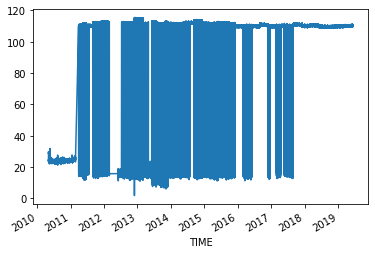

In [10]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
temp_df.PRES.plot()

In [11]:
temp_df.PRES.max(), temp_df.PRES.min()

(115.39, 1.78)

In [22]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 9*13, 13+1)
labs = np.linspace(5, 9*12+5, 12+1)

In [23]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs)

In [24]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [25]:
temp_df

TEMP
PRES_BIN TIME                          
5.0      2012-11-28 22:00:00  20.761765
         2013-06-14 19:00:00  19.125366
         2013-06-14 20:00:00  19.136484
         2013-06-14 21:00:00  19.166201
         2013-06-14 22:00:00  19.151501
...                                 ...
113.0    2019-06-11 22:00:00  18.039165
         2019-06-11 23:00:00  18.116667
         2019-06-12 00:00:00  18.139166
         2019-06-12 01:00:00  17.823334
         2019-06-12 02:00:00  17.805000

[118118 rows x 1 columns]

In [33]:
wqm_df

DOX2
PRES_BIN TIME                           
1.0      2012-11-28 22:00:00  219.715591
3.0      2012-11-28 22:00:00  219.631363
7.0      2013-06-15 07:00:00  205.350891
         2013-06-15 08:00:00  205.339203
         2013-06-15 21:00:00  208.561523
...                                  ...
31.0     2010-05-21 10:00:00  210.213242
         2010-05-21 11:00:00  210.027222
         2010-05-21 12:00:00  209.906219
         2016-04-01 05:00:00  161.294037
         2016-04-01 06:00:00  162.787338

[62732 rows x 1 columns]

In [34]:
# Join wqm_df and temp_df
mooring_df = wqm_df.join(temp_df, how='inner')

In [35]:
mooring_df

DOX2       TEMP
PRES_BIN TIME                                      
1.0      2012-11-28 22:00:00  219.715591  20.759911
3.0      2012-11-28 22:00:00  219.631363  20.770100
7.0      2013-06-15 07:00:00  205.350891  19.003767
         2013-06-15 08:00:00  205.339203  18.982601
         2013-06-15 21:00:00  208.561523  18.965900
...                                  ...        ...
31.0     2010-05-21 10:00:00  210.213242  22.698212
         2010-05-21 11:00:00  210.027222  22.679289
         2010-05-21 12:00:00  209.906219  22.679312
         2016-04-01 05:00:00  161.294037  24.785011
         2016-04-01 06:00:00  162.787338  24.770300

[62732 rows x 2 columns]

### Salinity data

In [26]:
psal = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_SZ_20100504_PH100_FV01_PSAL-aggregated-timeseries_END-20190612_C-20190822.nc')

In [28]:
psal

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 50, OBSERVATION: 12502147)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    PSAL                      (OBSERVATION) float32 ...
    PSAL_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256

In [29]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(psal.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  24. , 104. ], dtype=float32)

In [30]:
psal = psal.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [31]:
psal = psal.where(np.logical_and(psal.PSAL_quality_control > 0, psal.PSAL_quality_control < 3), drop = True)

In [32]:
psal = psal.where(np.logical_and(psal.PRES_REL_quality_control > 0, psal.PRES_REL_quality_control < 3), drop = True) 

In [33]:
# create pd dataframe from scratch
data  = {'TIME': psal.TIME.values,
         'PSAL': psal.PSAL.values,
         'PRES': psal.PRES_REL.values}

psal_df= pd.DataFrame(data, columns = ['TIME','PSAL','PRES'])
# set TIME as the indexing variable
psal_df = psal_df.set_index('TIME')

In [43]:
# subset to the same dates water quality measurements
psal_df = psal_df.loc['2010-05-04 02':'2017-8-27 18']

In [44]:
# subset to same pressure range as WQM
psal_df = psal_df.where(psal_df.PRES <= max_pres).dropna()

In [64]:
# temp_df = temp_df.loc[~temp_df.index.duplicated()]

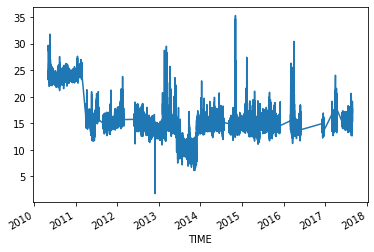

In [38]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
psal_df.PRES.plot()

In [46]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [47]:
# create a column with pressure bin labels
psal_df['PRES_BIN'] = pd.cut(psal_df.PRES, bins = bins, labels = labs)

In [48]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
psal_df = psal_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [49]:
psal_df

PSAL
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  35.461388
3.0      2012-11-28 22:00:00  35.460751
7.0      2013-06-15 07:00:00  35.462334
         2013-06-15 08:00:00  35.463001
         2013-06-15 21:00:00  35.501999
...                                 ...
31.0     2014-11-04 08:00:00  35.632832
         2014-11-04 09:00:00  35.634396
         2014-11-04 10:00:00  35.633755
         2016-04-01 05:00:00  35.544964
         2016-04-01 06:00:00  35.544453

[75665 rows x 1 columns]

In [50]:
# Join with mooring_df
mooring_df = mooring_df.join(psal_df, how="inner")

In [51]:
mooring_df

DOX2       TEMP       PSAL
PRES_BIN TIME                                                 
1.0      2012-11-28 22:00:00  219.715591  20.759911  35.461388
3.0      2012-11-28 22:00:00  219.631363  20.770100  35.460751
7.0      2013-06-15 07:00:00  205.350891  19.003767  35.462334
         2013-06-15 08:00:00  205.339203  18.982601  35.463001
         2013-06-15 21:00:00  208.561523  18.965900  35.501999
...                                  ...        ...        ...
31.0     2010-05-21 10:00:00  210.213242  22.698212  35.327530
         2010-05-21 11:00:00  210.027222  22.679289  35.324860
         2010-05-21 12:00:00  209.906219  22.679312  35.319817
         2016-04-01 05:00:00  161.294037  24.785011  35.544964
         2016-04-01 06:00:00  162.787338  24.770300  35.544453

[62732 rows x 3 columns]

In [55]:
mooring_df.groupby('PRES_BIN').count()

,DOX2,TEMP,PSAL
PRES_BIN,,,
1.0,1,1,1
3.0,1,1,1
7.0,189,189,189
9.0,3047,3047,3047
11.0,3382,3382,3382
13.0,8405,8405,8405
15.0,26249,26249,26249
17.0,9507,9507,9507
19.0,1071,1071,1071
